# LSTM Model for forecasting

Importing all necessary modules

In [11]:
from data import result_df
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
from keras import backend as K
from keras import optimizers
from keras.callbacks.callbacks import EarlyStopping
from keras.preprocessing.sequence import TimeseriesGenerator
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, TimeSeriesSplit, cross_validate

Removing Average Mean, Differential to become a little more efficient

In [12]:
X = result_df[['Open', 'High', 'Low', 'Polarity', 'Sentiment']]
y = result_df[['Close']]

Time series specific train-test-split

In [13]:
tscv = TimeSeriesSplit(n_splits=4)

for train_index, test_index in tscv.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

Scaling all values for a normalized input and output

In [14]:
min_max_scaler = MinMaxScaler()

# Changed fit_transform to transform for test fold to avoid data leakage from future test set
X_train = min_max_scaler.fit_transform(X_train)
X_test = min_max_scaler.transform(X_test)
y_train = min_max_scaler.fit_transform(y_train)
y_test = min_max_scaler.transform(y_test)

/usr/local/lib/python3.7/site-packages/sklearn/preprocessing/data.py:334: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


Using keras' timeseriesgenerator in order to divide the data into batches, putting data into 3D for input to the LSTM

In [15]:
data_gen_train = TimeseriesGenerator(X_train, y_train,
                               length=14, sampling_rate=1,
                               batch_size=160)

data_gen_test = TimeseriesGenerator(X_test, y_test,
                               length=14, sampling_rate=1,
                               batch_size=160)

# Done for Input shape of LSTM
train_X, train_y = data_gen_train[0]
test_X, test_y = data_gen_test[0]

# (32, 7, 5)
# print(train_X.shape)
# (32, 1)
# print(train_y)

Function for calculating r-squared as a metric for Keras

In [16]:
def r_squared(y_true, y_pred):
    SS_res = K.sum(K.square(y_true - y_pred))
    SS_tot = K.sum(K.square(y_true - K.mean(y_true)))
    return (1 - SS_res/(SS_tot + K.epsilon()))

Begin LSTM

In [17]:
model = Sequential()
# Remove dropout initially to let overfitting happen.

model.add(LSTM(units = 40, return_sequences = False, input_shape = (train_X.shape[1], train_X.shape[2])))
# model.add(Dropout(0.2)) #Drops 20% of layer to prevent overfitting

model.add(Dense(units = 1))

adam = optimizers.Adam(learning_rate = .0022)
model.compile(optimizer = adam, loss = 'mean_absolute_error', metrics=[r_squared])
history = model.fit_generator(data_gen_train, epochs = 200, validation_data = data_gen_test)
score = model.evaluate_generator(data_gen_test, verbose=0)

# MSE: 0.012109583243727684, R-squared: 0.9007326364517212 after 200 epochs, learning_rate = 0.0022, and 160 batch size, step size = 14
print("Mean-absolute-error: ", score[0])
print("R-squared: ", score[1])

Epoch 1/200
6/6 [==============================] - 0s 83ms/step - loss: 0.3485 - r_squared: -18.8016 - val_loss: 0.5620 - val_r_squared: -75.0328
Epoch 2/200
6/6 [==============================] - 0s 15ms/step - loss: 0.1793 - r_squared: -13.8745 - val_loss: 0.0374 - val_r_squared: 0.2227
Epoch 3/200
6/6 [==============================] - 0s 17ms/step - loss: 0.0983 - r_squared: -9.1553 - val_loss: 0.1209 - val_r_squared: -2.8405
Epoch 4/200
6/6 [==============================] - 0s 14ms/step - loss: 0.0502 - r_squared: -0.4414 - val_loss: 0.0380 - val_r_squared: 0.3557
Epoch 5/200
6/6 [==============================] - 0s 14ms/step - loss: 0.0341 - r_squared: 0.5603 - val_loss: 0.0321 - val_r_squared: 0.5599
Epoch 6/200
6/6 [==============================] - 0s 15ms/step - loss: 0.0267 - r_squared: 0.6244 - val_loss: 0.0462 - val_r_squared: 0.3714
Epoch 7/200
6/6 [==============================] - 0s 16ms/step - loss: 0.0247 - r_squared: 0.6901 - val_loss: 0.0346 - val_r_squared: 0.58

6/6 [==============================] - 0s 17ms/step - loss: 0.0208 - r_squared: 0.8125 - val_loss: 0.0336 - val_r_squared: 0.6408
Epoch 59/200
6/6 [==============================] - 0s 18ms/step - loss: 0.0280 - r_squared: 0.7786 - val_loss: 0.0421 - val_r_squared: 0.4674
Epoch 60/200
6/6 [==============================] - 0s 17ms/step - loss: 0.0213 - r_squared: 0.7391 - val_loss: 0.0242 - val_r_squared: 0.7804
Epoch 61/200
6/6 [==============================] - 0s 18ms/step - loss: 0.0209 - r_squared: 0.8015 - val_loss: 0.0255 - val_r_squared: 0.7099
Epoch 62/200
6/6 [==============================] - 0s 17ms/step - loss: 0.0203 - r_squared: 0.8179 - val_loss: 0.0471 - val_r_squared: 0.3285
Epoch 63/200
6/6 [==============================] - 0s 17ms/step - loss: 0.0217 - r_squared: 0.7800 - val_loss: 0.0380 - val_r_squared: 0.5623
Epoch 64/200
6/6 [==============================] - 0s 17ms/step - loss: 0.0198 - r_squared: 0.7900 - val_loss: 0.0218 - val_r_squared: 0.7972
Epoch 65/200

6/6 [==============================] - 0s 13ms/step - loss: 0.0264 - r_squared: 0.7733 - val_loss: 0.0308 - val_r_squared: 0.6882
Epoch 116/200
6/6 [==============================] - 0s 17ms/step - loss: 0.0237 - r_squared: 0.7314 - val_loss: 0.0187 - val_r_squared: 0.8354
Epoch 117/200
6/6 [==============================] - 0s 16ms/step - loss: 0.0196 - r_squared: 0.8165 - val_loss: 0.0555 - val_r_squared: 0.1296
Epoch 118/200
6/6 [==============================] - 0s 14ms/step - loss: 0.0235 - r_squared: 0.7682 - val_loss: 0.0497 - val_r_squared: 0.2600
Epoch 119/200
6/6 [==============================] - 0s 14ms/step - loss: 0.0222 - r_squared: 0.8331 - val_loss: 0.0202 - val_r_squared: 0.8301
Epoch 120/200
6/6 [==============================] - 0s 14ms/step - loss: 0.0208 - r_squared: 0.7268 - val_loss: 0.0199 - val_r_squared: 0.8166
Epoch 121/200
6/6 [==============================] - 0s 17ms/step - loss: 0.0172 - r_squared: 0.8673 - val_loss: 0.0276 - val_r_squared: 0.7387
Epoch 

Epoch 172/200
6/6 [==============================] - 0s 18ms/step - loss: 0.0175 - r_squared: 0.8790 - val_loss: 0.0147 - val_r_squared: 0.8853
Epoch 173/200
6/6 [==============================] - 0s 17ms/step - loss: 0.0163 - r_squared: 0.8574 - val_loss: 0.0213 - val_r_squared: 0.8245
Epoch 174/200
6/6 [==============================] - 0s 17ms/step - loss: 0.0160 - r_squared: 0.8351 - val_loss: 0.0202 - val_r_squared: 0.8168
Epoch 175/200
6/6 [==============================] - 0s 17ms/step - loss: 0.0155 - r_squared: 0.8890 - val_loss: 0.0207 - val_r_squared: 0.8296
Epoch 176/200
6/6 [==============================] - 0s 17ms/step - loss: 0.0136 - r_squared: 0.9049 - val_loss: 0.0163 - val_r_squared: 0.8748
Epoch 177/200
6/6 [==============================] - 0s 18ms/step - loss: 0.0134 - r_squared: 0.9060 - val_loss: 0.0179 - val_r_squared: 0.8591
Epoch 178/200
6/6 [==============================] - 0s 17ms/step - loss: 0.0136 - r_squared: 0.9067 - val_loss: 0.0148 - val_r_squared:

Plot of metrics and diagnostics - specifically of loss/val-loss

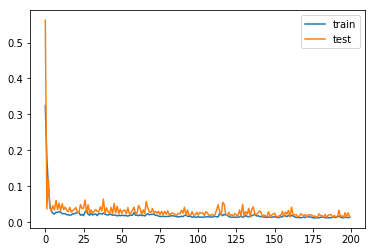

In [18]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

Plot of metrics and diagnostics - specifically of r-squared/val-r-squared

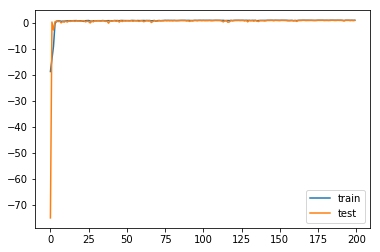

In [20]:
plt.plot(history.history['r_squared'], label='train')
plt.plot(history.history['val_r_squared'], label='test')
plt.legend()
plt.show()

Predicted Stock Prices

In [21]:
predicted_stock_price = model.predict(test_X)
predicted_stock_price = min_max_scaler.inverse_transform(predicted_stock_price)
print(predicted_stock_price)

[[1675.9568]
 [1665.4016]
 [1664.575 ]
 [1664.3158]
 [1658.1116]
 [1656.6475]
 [1680.4027]
 [1686.8788]
 [1710.42  ]
 [1724.4159]
 [1731.2048]
 [1732.6201]
 [1710.0457]
 [1674.6594]
 [1660.1061]
 [1677.6185]
 [1688.9114]
 [1695.8127]
 [1674.163 ]
 [1646.6555]
 [1664.0706]
 [1705.1399]
 [1683.4276]
 [1670.897 ]
 [1663.355 ]
 [1648.4225]
 [1663.2848]
 [1684.7808]
 [1654.7803]
 [1612.7743]
 [1601.2263]
 [1600.1475]
 [1613.989 ]
 [1638.8158]
 [1659.3356]
 [1647.5602]
 [1637.5961]
 [1633.4547]
 [1632.8333]
 [1632.376 ]
 [1627.4279]
 [1643.7465]
 [1640.7902]
 [1643.5352]
 [1643.9218]
 [1643.5404]
 [1652.0244]
 [1647.6459]
 [1646.2722]
 [1651.3488]
 [1679.3805]
 [1685.0479]
 [1684.2805]
 [1699.264 ]
 [1706.874 ]
 [1713.1445]
 [1683.8451]
 [1635.719 ]
 [1621.9138]
 [1619.6989]
 [1640.6984]
 [1683.6578]
 [1703.6289]
 [1699.4595]
 [1719.8341]
 [1721.2346]
 [1719.3046]
 [1727.1909]
 [1757.9387]
 [1787.9781]
 [1825.3312]
 [1808.2965]
 [1803.854 ]
 [1802.7454]
 [1797.0354]
 [1798.0133]
 [1782.5905]